# Business performance analysis 
We will calculate such indicators as: Conversion, bounce, retention, LVT, ROI, CAC and build charts to make it easier to analyze.

# Step 1 - Loading data and preparing it for analysis

In [1]:
# importing modules

import pandas as pd
import seaborn
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# import visit data
visits = pd.read_csv('data/visits_info_short.csv')
visits.head(2)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35


In [3]:
# rename table columns
visits = visits.rename(columns={'User Id': 'user_id',
                        'Region': 'region',
                        'Device': 'device',
                        'Channel': 'channel',
                        'Session Start': 'session_start',
                        'Session End': 'session_end'
                       })
visits.head(1)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


In [4]:
# import order data
orders = pd.read_csv('data/orders_info_short.csv')
orders.head(2)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99


In [5]:
# rename table columns
orders = orders.rename(columns={'User Id': 'user_id',
                        'Event Dt': 'event_dt',
                        'Revenue': 'revenue'
                       })
orders.head(1)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99


In [6]:
# import cost data
costs = pd.read_csv('data/costs_info_short.csv')
costs.head(2)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1


In [7]:
# rename table columns
costs = costs.rename(columns={'Channel': 'channel'
                       })
costs.head(1)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3


In [8]:
# check data for duplicates
print('Number of duplicates в visits:', visits.duplicated().sum())
print('Number of duplicates в orders:', orders.duplicated().sum())
print('Number of duplicates в costs:', costs.duplicated().sum())

Number of duplicates в visits: 0
Number of duplicates в orders: 0
Number of duplicates в costs: 0


In [9]:
# chcecking for gaps
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


- no duplicates were found in the datasets,
- the number of records in all datasets is the same
- no passes found

# Step 2 - we will set functions for calculating and analyzing LTV, ROI, retention and conversion.

In [12]:
# function to create user profiles

def get_profiles(sessions, orders, ad_costs):
    # Step 1. Pass data on advertising costs to the profile calculation function (ad_costs frame)
    
    # sort sessions by user id and date so that first works
    # find the first values for the user parameters - we will consider them the main ones 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # return all data from the index to the columns                                           
               )
    # determine the date of the first visit
    # and the beginning of the month of the first visit - we will need them for cohort analysis
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # add a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Step 2. Add the number of attracted users to the data on advertising costs
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Step 3. Find the average user acquisition cost
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Step 4. Attach data to user profiles with information about the average acquisition cost per day of user acquisition from the desired source
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # organic users will cost 0
    
    return profiles

In [13]:
# function to calculate retention

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # add the payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collect "raw" data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # get a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [14]:
# function for calculating conversion

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []

    # get a table of conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [15]:
# function for calculating LTV and ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # add purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculate LTV: divide each "cell" in the row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes

        # collect dataframe with user data and CAC values,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculate the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # add CAC to ROI table
        roi['cac'] = cac['cac']

        # in the final table we leave the sizes of cohorts, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return LTV and ROI tables
        return result, roi

    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables remove 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,      # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,     # ROI table
        roi_in_time,     # table of ROI dynamics
    )

In [16]:
# function to smooth the frame

def filter_data(df, window):
    # apply a moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [17]:
# function to visualize retention

def plot_retention(retention, retention_history, horizon, window=7):

    # set the grid size for charts
    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # leave only the desired lifetime in the dynamics table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if there is only payer in the indexes of the hold table,
    # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # in the graph table - two columns and two rows, four cells
    # in the first we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # in the second cell we build non-paying retention curves
    # vertical axis - from the graph from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # in the third cell - the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter the data and build a graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of paying users for day {}'.format(
            horizon
        )
    )

    # in the fourth cell - the dynamics of retention of non-paying
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter the data and build a graph
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of non-paying users for day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [18]:
# function to visualize the conversion

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # set the grid size for charts
    plt.figure(figsize=(15, 5))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first chart - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Engagement date')
    plt.title('User conversion')

    # second graph - conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all index columns except date will become pivot table columns
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Engagement date')
    plt.title('Dynamics of user conversion for day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# function to visualize LTV and ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # set the grid for drawing charts
    plt.figure(figsize=(20, 10))

    # exclude cohort sizes from table ltv
    ltv = ltv.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the ltv dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # exclude cohort sizes and cac from table roi
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # in the dynamics table roi leave only the desired lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

   # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second graph - ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Engagement date')
    plt.title('User LTV dynamics on the {} day'.format(horizon))

    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date')
    plt.title('User Acquisition Cost Dynamics')

    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Engagement date')
    plt.title('User ROI dynamics on the {} day'.format(horizon))

    plt.tight_layout()
    plt.show()

# Step 3 - Exploratory data analysis (EDA)

Let's build user profiles. Determine the minimum and maximum date for attracting users.

will answer questions

- What countries do visitors come from? Which countries have the most paying users?
- What devices do they use? What devices do paying users visit most often?
- What advertising channels were used to attract users? Which channels bring in the most paying users?


In [20]:
visits.head()


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [21]:
# converting time data
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [22]:
observation_date = datetime(2019, 11, 1).date()  # moment of analysis
horizon_days = 14  # analysis horizon

In [23]:
# get user profiles
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


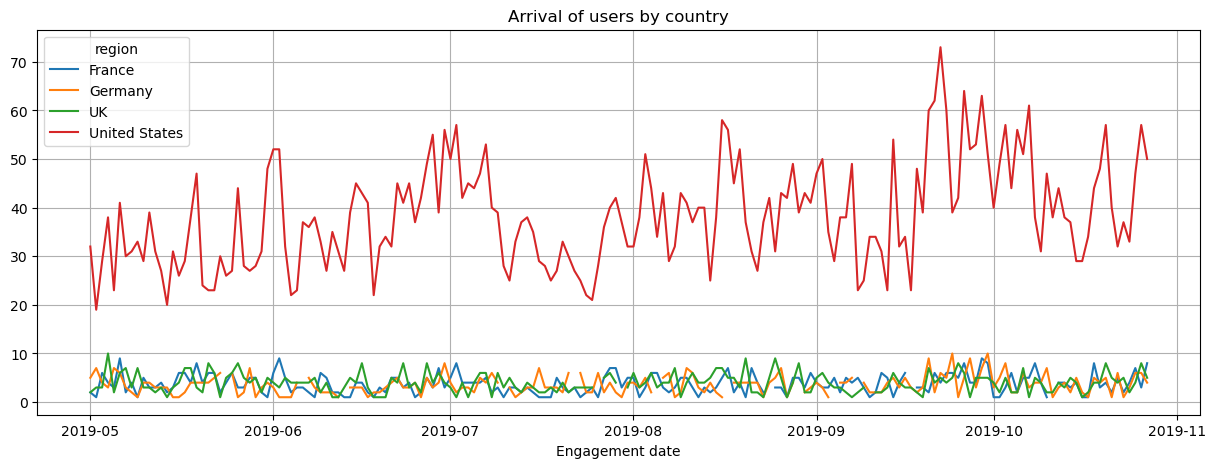

In [24]:
# What countries do visitors come from? 
# Which countries have the most paying users?

profiles.query('payer == True').pivot_table(
    index='dt',        # dates of first visits
    columns='region',  # transition country
    values='user_id',  # User IDs
    aggfunc='nunique'  # counting unique values
).plot(figsize=(15, 5), grid=True)
plt.xlabel('Engagement date')
plt.title('Arrival of users by country')
plt.show()

On average, 6 times more customers come from the USA than from other countries, which is understandable, the US population is much larger.

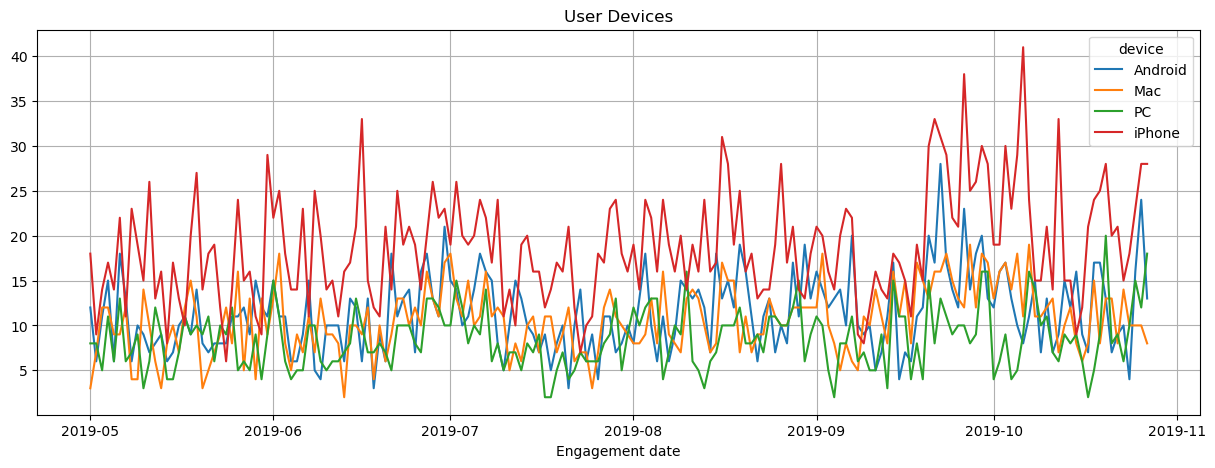

In [25]:
# What devices do they use? 
# What devices do paying users visit most often?

profiles.query('payer == True').pivot_table(
    index='dt',        # dates of first visits
    columns='device',  # transition device
    values='user_id',  # User IDs
    aggfunc='nunique'  # counting unique values
).plot(figsize=(15, 5), grid=True)

plt.xlabel('Engagement date')
plt.title('User Devices')

plt.show()

Most referrals from iphone

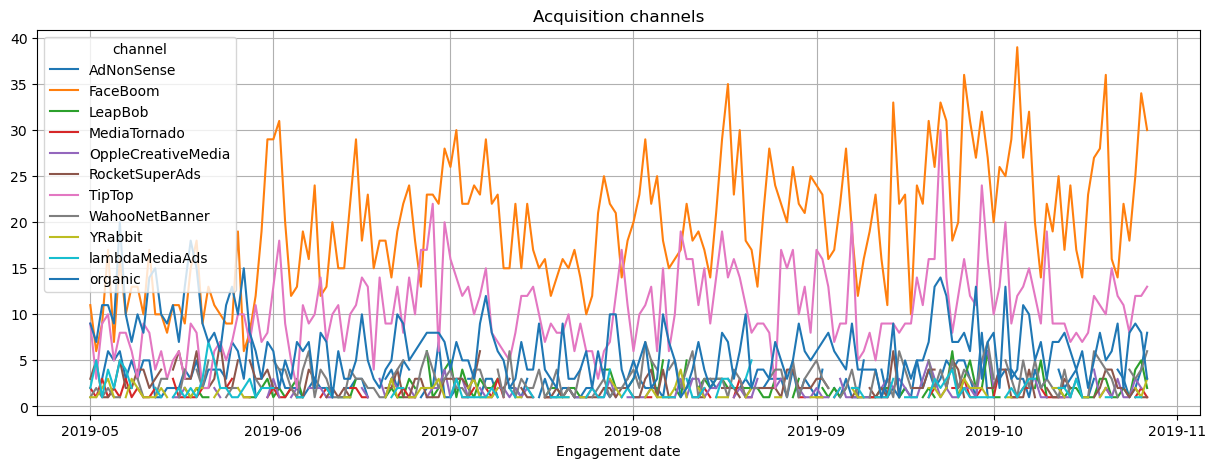

In [26]:
# What advertising channels did you use to attract users? 
# Which channels bring in the most paying users?

profiles.query('payer == True').pivot_table(
    index='dt',         # dates of first visits
    columns='channel',  # referral sources
    values='user_id',   # User IDs
    aggfunc='nunique'   # counting unique values
).plot(figsize=(15, 5), grid=True)

plt.xlabel('Engagement date')
plt.title('Acquisition channels')

plt.show()

AdNoSense Leading Customer Acquisition

In [27]:
profiles.head(2)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237


In [28]:
# share of paying users by country
user_by_region = pd.DataFrame(profiles.pivot_table(index='region', values='user_id', aggfunc='count'))
user_by_region.columns = ['user_cout']
user_by_region.reset_index()


paing_user_by_region = pd.DataFrame(profiles.query('payer == True').pivot_table(index='region', values='user_id', aggfunc='count'))
paing_user_by_region.columns = ['paing_user_cout']
paing_user_by_region.reset_index()

tab = pd.merge(user_by_region, paing_user_by_region, 'left', on = 'region')
tab['part'] = (tab['paing_user_cout'] / tab['user_cout']) * 100
tab

,user_cout,paing_user_cout,part
region,,,
France,17450,663,3.799427
Germany,14981,616,4.111875
UK,17575,700,3.982930
United States,100002,6902,6.901862


In [29]:
# share of paying users by device

user_by_device = pd.DataFrame(profiles.pivot_table(index='device', values='user_id', aggfunc='count'))
user_by_device.columns = ['user_cout']
user_by_device.reset_index()


paing_user_by_device = pd.DataFrame(profiles.query('payer == True').pivot_table(index='device', values='user_id', aggfunc='count'))
paing_user_by_device.columns = ['paing_user_cout']
paing_user_by_device.reset_index()

user_part_device = pd.merge(user_by_device, paing_user_by_device, 'left', on = 'device')
user_part_device['part'] = (user_part_device['paing_user_cout'] / user_part_device['user_cout']) * 100
user_part_device

,user_cout,paing_user_cout,part
device,,,
Android,35032,2050,5.851793
Mac,30042,1912,6.364423
PC,30455,1537,5.046790
iPhone,54479,3382,6.207897


In [30]:
# share of paying users by acquisition channels

user_by_channel = pd.DataFrame(profiles.pivot_table(index='channel', values='user_id', aggfunc='count'))
user_by_channel.columns = ['user_cout']
user_by_channel.reset_index()


paing_user_by_channel = pd.DataFrame(profiles.query('payer == True').pivot_table(index='channel', values='user_id', aggfunc='count'))
paing_user_by_channel.columns = ['paing_user_cout']
paing_user_by_channel.reset_index()

user_part_channel = pd.merge(user_by_channel, paing_user_by_channel, 'left', on = 'channel')
user_part_channel['part'] = (user_part_channel['paing_user_cout'] / user_part_channel['user_cout']) * 100
user_part_channel.sort_values(by='part',ascending=False)

,user_cout,paing_user_cout,part
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


In [31]:
# maximum engagement date
max_acquisition_date = profiles.reset_index()['dt'].max()

# minimum engagement date
min_acquisition_date = profiles.reset_index()['dt'].min()

print('Maximum engagement date:', max_acquisition_date)
print('Minimum engagement date:', min_acquisition_date)

Maximum engagement date: 2019-10-27
Minimum engagement date: 2019-05-01


# Step 4 - Marketing

Find out:
- How much money have you spent? Total / per source / by time
- How much did it cost on average to acquire one customer from each source?